## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

### Goals:
#### Use Scikit-Learn pipelines to define special features to add to a Naive Bayes Classifier
#### Evaluate the accuracy of the classifier
#### Maybe do it live, on a Twitter API stream

### Methods:
#### Use the training set I made before

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from textblob import TextBlob
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import re

#### Set max column width for dataframes

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the CSV

In [4]:
df = pd.read_csv("../data/training_data/Subtweets_Classifier_Training_Data.csv")

#### Create training and test sets from the single training set I made before

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df.alleged_subtweet.tolist(), 
                                                                  df.is_subtweet.tolist())

#### Use NLTK's tokenizer instead of Scikit's

In [6]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [7]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        first_names = ["Aaliyah", "Aaron", "Abby", "Abigail", "Abraham", "Adam",
                       "Addison", "Adrian", "Adriana", "Adrianna", "Aidan", "Aiden",
                       "Alan", "Alana", "Alejandro", "Alex", "Alexa", "Alexander",
                       "Alexandra", "Alexandria", "Alexia", "Alexis", "Alicia", "Allison",
                       "Alondra", "Alyssa", "Amanda", "Amber", "Amelia", "Amy",
                       "Ana", "Andrea", "Andres", "Andrew", "Angel", "Angela",
                       "Angelica", "Angelina", "Anna", "Anthony", "Antonio", "Ariana",
                       "Arianna", "Ashley", "Ashlyn", "Ashton", "Aubrey", "Audrey",
                       "Austin", "Autumn", "Ava", "Avery", "Ayden", "Bailey",
                       "Benjamin", "Bianca", "Blake", "Braden", "Bradley", "Brady",
                       "Brandon", "Brayden", "Breanna", "Brendan", "Brian", "Briana",
                       "Brianna", "Brittany", "Brody", "Brooke", "Brooklyn", "Bryan",
                       "Bryce", "Bryson", "Caden", "Caitlin", "Caitlyn", "Caleb",
                       "Cameron", "Camila", "Carlos", "Caroline", "Carson", "Carter",
                       "Cassandra", "Cassidy", "Catherine", "Cesar", "Charles", "Charlotte",
                       "Chase", "Chelsea", "Cheyenne", "Chloe", "Christian", "Christina",
                       "Christopher", "Claire", "Cody", "Colby", "Cole", "Colin",
                       "Collin", "Colton", "Conner", "Connor", "Cooper", "Courtney",
                       "Cristian", "Crystal", "Daisy", "Dakota", "Dalton", "Damian",
                       "Daniel", "Daniela", "Danielle", "David", "Delaney", "Derek",
                       "Destiny", "Devin", "Devon", "Diana", "Diego", "Dominic",
                       "Donovan", "Dylan", "Edgar", "Eduardo", "Edward", "Edwin",
                       "Eli", "Elias", "Elijah", "Elizabeth", "Ella", "Ellie", 
                       "Emily", "Emma", "Emmanuel", "Eric", "Erica", "Erick",
                       "Erik", "Erin", "Ethan", "Eva", "Evan", "Evelyn",
                       "Faith", "Fernando", "Francisco", "Gabriel", "Gabriela", "Gabriella",
                       "Gabrielle", "Gage", "Garrett", "Gavin", "Genesis", "George",
                       "Gianna", "Giovanni", "Giselle", "Grace", "Gracie", "Grant",
                       "Gregory", "Hailey", "Haley", "Hannah", "Hayden", "Hector",
                       "Henry", "Hope", "Hunter", "Ian", "Isaac", "Isabel",
                       "Isabella", "Isabelle", "Isaiah", "Ivan", "Jack", "Jackson",
                       "Jacob", "Jacqueline", "Jada", "Jade", "Jaden", "Jake",
                       "Jalen", "James", "Jared", "Jasmin", "Jasmine", "Jason", 
                       "Javier", "Jayden", "Jayla", "Jazmin", "Jeffrey", "Jenna",
                       "Jennifer", "Jeremiah", "Jeremy", "Jesse", "Jessica", "Jesus",
                       "Jillian", "Jocelyn", "Joel", "John", "Johnathan", "Jonah",
                       "Jonathan", "Jordan", "Jordyn", "Jorge", "Jose", "Joseph",
                       "Joshua", "Josiah", "Juan", "Julia", "Julian", "Juliana",
                       "Justin", "Kaden", "Kaitlyn", "Kaleb", "Karen", "Karina",
                       "Kate", "Katelyn", "Katherine", "Kathryn", "Katie", "Kayla",
                       "Kaylee", "Kelly", "Kelsey", "Kendall", "Kennedy", "Kenneth",
                       "Kevin", "Kiara", "Kimberly", "Kyle", "Kylee", "Kylie",
                       "Landon", "Laura", "Lauren", "Layla", "Leah", "Leonardo",
                       "Leslie", "Levi", "Liam", "Liliana", "Lillian", "Lilly",
                       "Lily", "Lindsey", "Logan", "Lucas", "Lucy", "Luis",
                       "Luke", "Lydia", "Mackenzie", "Madeline", "Madelyn", "Madison",
                       "Makayla", "Makenzie", "Malachi", "Manuel", "Marco", "Marcus",
                       "Margaret", "Maria", "Mariah", "Mario", "Marissa", "Mark",
                       "Martin", "Mary", "Mason", "Matthew", "Max", "Maxwell",
                       "Maya", "Mckenzie", "Megan", "Melanie", "Melissa", "Mia",
                       "Micah", "Michael", "Michelle", "Miguel", "Mikayla", "Miranda",
                       "Molly", "Morgan", "Mya", "Naomi", "Natalia", "Natalie",
                       "Nathan", "Nathaniel", "Nevaeh", "Nicholas", "Nicolas", "Nicole",
                       "Noah", "Nolan", "Oliver", "Olivia", "Omar", "Oscar",
                       "Owen", "Paige", "Parker", "Patrick", "Paul", "Payton",
                       "Peter", "Peyton", "Preston", "Rachel", "Raymond", "Reagan",
                       "Rebecca", "Ricardo", "Richard", "Riley", "Robert", "Ruby",
                       "Ryan", "Rylee", "Sabrina", "Sadie", "Samantha", "Samuel",
                       "Sara", "Sarah", "Savannah", "Sean", "Sebastian", "Serenity",
                       "Sergio", "Seth", "Shane", "Shawn", "Shelby", "Sierra",
                       "Skylar", "Sofia", "Sophia", "Sophie", "Spencer", "Stephanie",
                       "Stephen", "Steven", "Summer", "Sydney", "Tanner", "Taylor", 
                       "Thomas", "Tiffany", "Timothy", "Travis", "Trenton", "Trevor",
                       "Trinity", "Tristan", "Tyler", "Valeria", "Valerie", "Vanessa",
                       "Veronica", "Victor", "Victoria", "Vincent", "Wesley", "William",
                       "Wyatt", "Xavier", "Zachary", "Zoe", "Zoey"]
        first_names_lower = set([name.lower() for name in first_names])

        pronouns = ["You", "You're", "Your", 
                    "She", "She's", "Her", "Hers", 
                    "He", "He's", "Him", "His", 
                    "They", "They're", "Them", "Their", "Theirs"]
        prounouns_lower = set([pronoun.lower() for pronoun in pronouns])

        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            weighted_dict = {"length": len(text), 
                             "good": len(prounouns_lower.intersection(tokenized_text)), 
                             "bad": (len(first_names_lower.intersection(tokenized_text)) 
                                     + text.count("@") 
                                     + text.count("subtweet") 
                                     + text.count("Subtweet") 
                                     + len(re.findall(pattern, text)))}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [8]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer()),
        ])),
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [9]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [10]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.94      0.87      0.90      1829
   positive       0.88      0.94      0.91      1854

avg / total       0.91      0.90      0.90      3683



#### Define function for visualizing confusion matrices

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

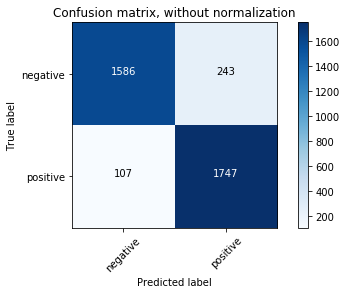

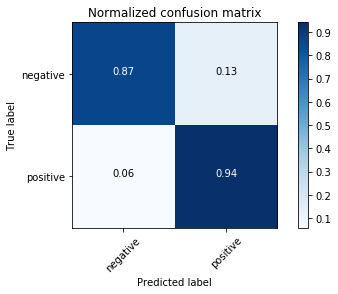

In [12]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [13]:
joblib.dump(sentiment_pipeline, "../data/non_subtweets_data/subtweets_classifier.pkl") 

['../data/non_subtweets_data/subtweets_classifier.pkl']

#### Print tests for the classifier

In [14]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [15]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [16]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [17]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1,None,0.060241,0.939759,Isn't it funny how some people don't know their place?
2,None,0.060887,0.939113,How come you people act like this?
0,None,0.063270,0.936730,Some people don't know their place.
3,None,0.423254,0.576746,You're such a nerd.
7,None,0.633780,0.366220,This is a subtweet.


#### Test on actual tweets

In [18]:
naji_df = pd.read_csv("../data/non_subtweets_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [19]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [20]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [21]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [22]:
len(naji_df)

1564156

#### Use randomly selected 500K rows from dataset

In [23]:
naji_df = naji_df.sample(n=500000).reset_index(drop=True)

#### Print and time the tests

In [24]:
%%time
naji_df = tests_dataframe(naji_df)

CPU times: user 1min 38s, sys: 1.65 s, total: 1min 40s
Wall time: 1min 40s


In [25]:
naji_df.to_csv("../data/non_subtweets_data/naji_tests.csv")

In [26]:
naji_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
150961,0,0.009316,0.990684,You know what I hate when people spend every minute with their boyfriends and never have time for their friends anymore
177717,0,0.010731,0.989269,why is that when you feel someone? they don feel for you back... i hate feelings man
269954,0,0.010752,0.989248,don't you just hate it when you're talking to someone on MSN and they don't respond for ages and you think you've made them upset
367181,0,0.010810,0.989190,Hate men who sit directly in front of you with legs wide open. Like they're showing off their masculinity to you or something
299696,0,0.010839,0.989161,People who allude to their problems but don't explain them make me really worried about them. I care about people a bit too much I think.


#### Tests on friends' tweets

In [27]:
aaron_df = pd.read_csv("../data/friends_tweets/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [28]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 619 ms, sys: 12.3 ms, total: 631 ms
Wall time: 633 ms


In [29]:
aaron_df.to_csv("../data/friends_tweets/akrapf96_tests.csv")

In [30]:
aaron_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2893,None,0.009620,0.990380,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
1784,None,0.018352,0.981648,When your professor tells a student to leave class to go get their book \nWhat if they live on North campus?\nSorry kid
1722,None,0.019042,0.980958,"PewDiePie posts video ""apologizing"" for his Kill All Jews ""joke"" and it's really about how he makes a ton of money and the media hates him"
225,None,0.019301,0.980699,"Can people stop putting eggs in their dog's mouths, one of them is gonna choke on it"
3236,None,0.019434,0.980566,"What will straight cis people do now with their ""legalize gay"" shirts? Frame them, probably"


In [31]:
julia_df = pd.read_csv("../data/friends_tweets/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [32]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.54 s, sys: 24.5 ms, total: 1.57 s
Wall time: 1.62 s


In [33]:
julia_df.to_csv("../data/friends_tweets/juliaeberry_tests.csv")

In [34]:
julia_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
773,None,0.006374,0.993626,"""I do feel grateful for the fact that we have one another, because I think people search their whole lives for someone that special"" -tessa\n\nwho even says this about somebody that they don't want to marry/be with forever? v/m soundbytes will be the death of me #virtuemoir"
1138,None,0.006738,0.993262,"""what a COINcidence that you're here,"" drawls Bitcoin lustily. your palms sweat as you imagine what it would be like to own this creature, to do with him what you will. you drag your cursor over his coinhood, and he gasps. \n""transaction complete,"" you whisper into his ear la..."
1799,None,0.007164,0.992836,"it really doesn't help that the sample ethnography my prof gave us is about sexism in jazz departments, an actual Serious Topic and Issue, and i'm just like, people sometimes feel isolated at their carrels, but also they sometimes feel a sense of community :-)"
3375,None,0.009230,0.990770,"""let me ask u this, who is the number one enemy of homosexuals? that’s right, rednecks. claudius married his brother’s wife and hates plays"""
663,None,0.010436,0.989564,even if you are committed to cheating how can you possibly think that p/c are on the same level as v/m when you're watching papadakis shakily clamber onto cizeron for a lift in their short dance after you've just seen tessa hook her legs around scott's head and spin in THEIR ...


In [35]:
zoe_df = pd.read_csv("../data/friends_tweets/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [36]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 266 ms, sys: 6.45 ms, total: 273 ms
Wall time: 281 ms


In [37]:
zoe_df.to_csv("../data/friends_tweets/zoeterhune_tests.csv")

In [38]:
zoe_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1304,None,0.002117,0.997883,maybe girls don’t “go for nice guys” bc they’re too busy going for nice girls
1186,None,0.006694,0.993306,no offense but what kind of school doesn’t let students park in a lot that’s literally called the main lot
318,None,0.007774,0.992226,bc she’s pURDY
584,None,0.008940,0.991060,the funny thing about anxiety is one minute you could be playing one of your favorite tabletop games w some of your favorite people and then the next you could be having a panic attack in the bathroom bc three people laughing/yelling (in jest) at you suddenly set something off
277,None,0.008960,0.991040,ok so people from my old school keep lamenting the death of someone to whom they claim to be close but also like continually misgender them in their lamentations?? I Don't Like This


In [39]:
noah_df = pd.read_csv("../data/friends_tweets/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [40]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 821 ms, sys: 14.6 ms, total: 835 ms
Wall time: 841 ms


In [41]:
noah_df.to_csv("../data/friends_tweets/noahsegalgould_tests.csv")

In [42]:
noah_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
877,None,0.000489,0.999511,I guess I think it’s foolish to rely on any website for being your source of personal fulfillment and especially as your only source for political change. The companies which own your speech aren’t going to let you dismantle them. And their goal isn’t ever going to be to help...
607,None,0.001631,0.998369,I don’t fuck with the symmetrarians
105,None,0.001636,0.998364,"In a target parking lot, I see him: he’s carrying a frozen Starbucks beverage that doesn’t appear to be coffee and his hood is missing a drawstring, so the wind keeps blowing it down. I don’t know his name, but I want to."
608,None,0.002087,0.997913,If your face is symmetrical I don’t like you
1503,None,0.003146,0.996854,Honestly I don’t remember


#### Test it in realtime
#### Define some useful variables for later

In [43]:
THRESHOLD = 0.95
DURATION = 21600 # 6 hours

#### Load Twitter API credentials

In [44]:
consumer_key, consumer_secret, access_token, access_token_secret = open("../../credentials.txt").read().split("\n")

#### Prepare the final dataframe

In [45]:
subtweets_live_list = []

#### Create a custom class for streaming subtweets

In [46]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        text = status.text
        
        #negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        
        screen_name = status.user.screen_name
        created_at = status.created_at
        
        sentiment = TextBlob(text).sentiment
        
        sentiment_polarity = sentiment.polarity
        sentiment_subjectivity = sentiment.subjectivity
        
        row = {"tweet": text, 
               "screen_name": screen_name, 
               "time": created_at, 
               "subtweet_probability": positive_probability, 
               "sentiment_polarity": sentiment_polarity, 
               "sentiment_subjectivity": sentiment_subjectivity}
        print_list = pd.DataFrame([row]).values.tolist()[0]
        
        if all([positive_probability >= THRESHOLD,
                not status.retweeted,
                "RT @" not in text, 
                not status.in_reply_to_status_id]):
            
            subtweets_live_list.append(row)
            
            print("Subtweet:")
            print(print_list)
            
            return row
        else:
            print("Not a subtweet:")
            print(print_list)

#### Use the API credentials to connect to the API

In [47]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, retry_delay=5, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, )

#### Create a list of all my followers' account IDs

In [48]:
my_followers_int = list(set(list(tweepy.Cursor(api.followers_ids, screen_name="NoahSegalGould").pages())[0]))
my_followers_str = [str(i) for i in my_followers_int]

#### Instantiate the listener

In [49]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [50]:
%%time
stream.filter(follow=my_followers_str, async=True)
print("Columns:")
print("screen_name, sentiment_polarity, sentiment_subjectivity, subtweet_probability, time, text")
sleep(DURATION)
stream.disconnect()

Columns:
screen_name, sentiment_polarity, sentiment_subjectivity, subtweet_probability, time, text


/Users/Noah/anaconda/envs/work/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Not a subtweet:
['itssaphiyah', 0.0, 0.16666666666666666, 7.811913195860426e-05, Timestamp('2018-03-11 08:36:34'), 'RT @johnhall: 12 Female #Entrepreneurs You Should Know (via @Entrepreneur): https://t.co/TjXJVBiDL0 https://t.co/zj89K2LfQg']
Not a subtweet:
['RobinDraastens', 0.0, 0.0, 0.3301423411879502, Timestamp('2018-03-11 08:40:45'), 'RT @Laurens_deGroot: Is het #CDA nu zo huiverig geworden voor groeiend verzet tegen de #bioindustrie dat ze het op de man gaan spelen? De b…']
Not a subtweet:
['modakbest', 0.0, 0.0, 8.309354736745525e-05, Timestamp('2018-03-11 08:47:41'), 'RT @ow: Oh my God Google Maps Mario mode  https://t.co/96LCsyXFC9 https://t.co/uNdKBVSMzs']
Not a subtweet:
['akrapf96', 0.0, 0.0, 0.25464516047924207, Timestamp('2018-03-11 08:56:33'), 'RT @N04H5G: The death of an icon']
Not a subtweet:
['chaancers', 0.8, 1.0, 0.01777820705176939, Timestamp('2018-03-11 08:57:00'), 'RT @futchaIex: one mississippi is making me tear up on this train i hope tig notaro is happy with h

Not a subtweet:
['Phoenix_909', 0.0, 0.0, 0.038907604881971085, Timestamp('2018-03-11 12:10:52'), 'RT @extrafabulous: https://t.co/bj7RVOhs4d']
Not a subtweet:
['trevornoahebook', 0.0, 0.0, 0.9428919801113652, Timestamp('2018-03-11 12:14:01'), 'That’s mom’s debt was never took flight.']
Not a subtweet:
['allchriscrossd', 0.3125, 0.625, 0.0021519096376264027, Timestamp('2018-03-11 12:17:21'), 'RT @extrafabulous: pls buy an original comic thank you https://t.co/ba7HghctXH https://t.co/Zg1bSpaNQ5']
Not a subtweet:
['jaypatricksmith', 0.08333333333333334, 0.5416666666666667, 0.5456406391750055, Timestamp('2018-03-11 12:20:54'), 'RT @homoposts: younger me: why am I so obsessed with gay people\n\nme now: I am a gay people']
Not a subtweet:
['jaypatricksmith', 0.0, 0.0, 0.024670053603687025, Timestamp('2018-03-11 12:21:05'), 'RT @jinteIlect: me when i found out twitters suspending accounts for cursing https://t.co/KV3CMCa0HV']
Not a subtweet:
['TriggerCap', 0.0, 0.0, 0.038907604881971085, Tim

Not a subtweet:
['tanugulati79', 0.5, 1.0, 6.0720200267716535e-05, Timestamp('2018-03-11 14:12:29'), 'RT @johnhall: 3 Guidelines for Navigating the Era of Audible #Branding (via @Adweek): https://t.co/clZUI0H703 https://t.co/PqBFmlxZl3']
Not a subtweet:
['C_A_Showcase', 0.5, 1.0, 6.0720200267716535e-05, Timestamp('2018-03-11 14:12:48'), 'RT @johnhall: 3 Guidelines for Navigating the Era of Audible #Branding (via @Adweek): https://t.co/clZUI0H703 https://t.co/PqBFmlxZl3']
Not a subtweet:
['jizzyjtiz', 0.0, 0.0, 0.018336747917479034, Timestamp('2018-03-11 14:13:23'), '@koshertwink You see!!!!']
Not a subtweet:
['trevornoahebook', 0.0, 0.0, 0.9029566353304552, Timestamp('2018-03-11 14:13:59'), 'She took the cradle and the why it was a trick, for whipping.” Even though she gets?']
Not a subtweet:
['mgstudiografico', 0.5, 1.0, 6.0720200267716535e-05, Timestamp('2018-03-11 14:17:28'), 'RT @johnhall: 3 Guidelines for Navigating the Era of Audible #Branding (via @Adweek): https://t.co/clZUI0H7

#### Save the dataframe

In [51]:
subtweets_df = pd.DataFrame(subtweets_live_list).sort_values(by="subtweet_probability", ascending=False)
subtweets_df.to_csv("../data/non_subtweets_data/live_data.csv")

#### Show the dataframe

In [52]:
subtweets_df

,screen_name,sentiment_polarity,sentiment_subjectivity,subtweet_probability,time,tweet
0,trevornoahebook,0.0,0.0,0.993664,2018-03-11 10:13:59,The thing would still don’t.
1,trevornoahebook,0.0,0.0,0.962205,2018-03-11 11:14:00,So now wasn’t rage or if you ran.
